# Cosmology project: Measuring Cosmic acceleration with Type Ia Supernovaes

Authors: Oriol Abril Pla, Mariona Badenas Agusti

April 2018

In [1]:
%matplotlib inline
%config IPython.matplotlib.backend = "retina"

import pandas as pd
import matplotlib.pyplot as plt

import scipy.optimize as opt
import scipy.integrate as pyint
import scipy.constants as const
import scipy.stats as stat
import numpy as np

import astropy.modeling.models as amod
import astropy.modeling.fitting as afit

from matplotlib import rcParams
rcParams['figure.figsize'] = 10, 7
#rcParams['figure.figsize'] = 5.5, 3.2
rcParams["figure.dpi"] = 150
rcParams["savefig.dpi"] = 150

#### Load the data
Load the sample from Union2 SNe and select only the desired coordinates.

In [2]:
database_file = 'SCPUnion2.1_AllSNe.txt'
SNe_df = pd.read_csv(database_file,header=None, sep=r'\)?\s+&\s+', engine='python', na_filter = ['\nodata','\nodata\\'],
                    names=['ID', 'z', 'mb',  'x1', 'color',
                           'd_mod', 'unknown', 'sample', 'Cuts Failed']).set_index('ID')
SNe_df['Cuts Failed'] = SNe_df['Cuts Failed'].str.slice(stop=-2)
SNe_df.info()
SNe_df = SNe_df[SNe_df['Cuts Failed']=='\\nodata']
SNe_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 753 entries, 1993ah to X-026
Data columns (total 8 columns):
z              753 non-null float64
mb             753 non-null object
x1             753 non-null object
color          753 non-null object
d_mod          753 non-null object
unknown        753 non-null object
sample         753 non-null float64
Cuts Failed    753 non-null object
dtypes: float64(2), object(6)
memory usage: 52.9+ KB
<class 'pandas.core.frame.DataFrame'>
Index: 580 entries, 1993ah to Z-005
Data columns (total 8 columns):
z              580 non-null float64
mb             580 non-null object
x1             580 non-null object
color          580 non-null object
d_mod          580 non-null object
unknown        580 non-null object
sample         580 non-null float64
Cuts Failed    580 non-null object
dtypes: float64(2), object(6)
memory usage: 40.8+ KB


In [3]:
def split_errors(df,name):
    #print df.loc[df[name]==na][name]
    mask = df[name].str.slice(start=-6)=='nodata'
    df.loc[mask, name] = 'NaN(NaN'
    split_df = df[name].str.split('(',expand=True)
    df[name] = split_df[0].astype(float)
    df['err_{}'.format(name)] = split_df[1].astype(float)
split_errors(SNe_df,'mb')
split_errors(SNe_df,'x1')
split_errors(SNe_df,'color')
split_errors(SNe_df,'d_mod')
nice_columns = ['z', 'mb', 'err_mb',  'color', 'err_color',
                           'd_mod', 'err_d_mod', 'x1', 'err_x1']
SNe_df = SNe_df[nice_columns]
SNe_df.head()

,z,mb,err_mb,color,err_color,d_mod,err_d_mod,x1,err_x1
ID,,,,,,,,,
1993ah,0.0285,16.86,0.19,0.23,0.09,35.35,0.22,-2.26,0.93
1993ag,0.0500,17.79,0.05,0.12,0.02,36.68,0.17,-1.09,0.24
1993o,0.0529,17.60,0.05,-0.01,0.02,36.82,0.16,-1.03,0.14
1993b,0.0701,18.43,0.04,0.09,0.02,37.45,0.16,-0.53,0.21
1992bs,0.0627,18.25,0.05,0.02,0.02,37.48,0.16,-0.27,0.23


In [4]:
C_sys = np.loadtxt('SCPUnion2.1_covmat_sys.txt')
C_nosys = np.loadtxt('SCPUnion2.1_covmat_nosys.txt')
sigma_ext = np.diag(C_nosys)

## Find cosmological parameters 
### Flat universe and w=0
[2018-04-05] The fit is performed directly with `scipy.optimize.curve_fit`, because it already allows to weight the values with its error. However, one method of our own or from github or comething could be implemented.

[2018-04-10] The fitting is now done with `astropy.modelling`.

In [5]:
def Hz_flatLCDM(z,Ode,H0=73.8):
    '''
    Flat Lambda-CDM model with H0 from Riess 2016 and k=0 fixed
    '''
    Om = 1-Ode
    Hz = H0*np.sqrt(Om*(1+z)**3+Ode)
    return Hz

def chi(zvec,Hz_fun,args):
    chi = const.c/1000*np.array([pyint.quad(lambda zz: 1./Hz_fun(zz,*args),0,z)[0] for z in zvec])
    return chi

def dist_lum(z,Hz_fun,args):
    return chi(z,Hz_fun,args)*(1+z)

def dist_mod(z,Hz_fun,args):
    D_L = dist_lum(z,Hz_fun,args)
    return 5*np.log10(D_L)+25

#H0 = 73.24
# Create astropy model
flatLCDM_aModel = amod.custom_model(lambda z,Ode=.7 : dist_mod(z,Hz_flatLCDM,(Ode,)))
 
z_grid = np.linspace(1e-4,1.4,100)
mask = np.isfinite(SNe_df['z']) & np.isfinite(SNe_df['d_mod'])

init_flatLCDM = flatLCDM_aModel()
fit_flatLCDM = afit.LevMarLSQFitter()
flatLCDM_result = fit_flatLCDM(init_flatLCDM,
                               SNe_df[mask]['z'],
                               SNe_df[mask]['d_mod'],
                               weights=SNe_df[mask]['err_d_mod'])
flatLCDM_Ode_err = np.sqrt(np.diag(fit_flatLCDM.fit_info['param_cov']))[0]
Ode = flatLCDM_result.Ode.value
Om = 1-Ode

In [6]:
print 'The fitted values are:\n\tOde : {:.3f}({:.2f})'.format(Ode,flatLCDM_Ode_err)

The fitted values are:
	Ode : 0.918(0.02)


Text(0,0.5,'Distance modulus')

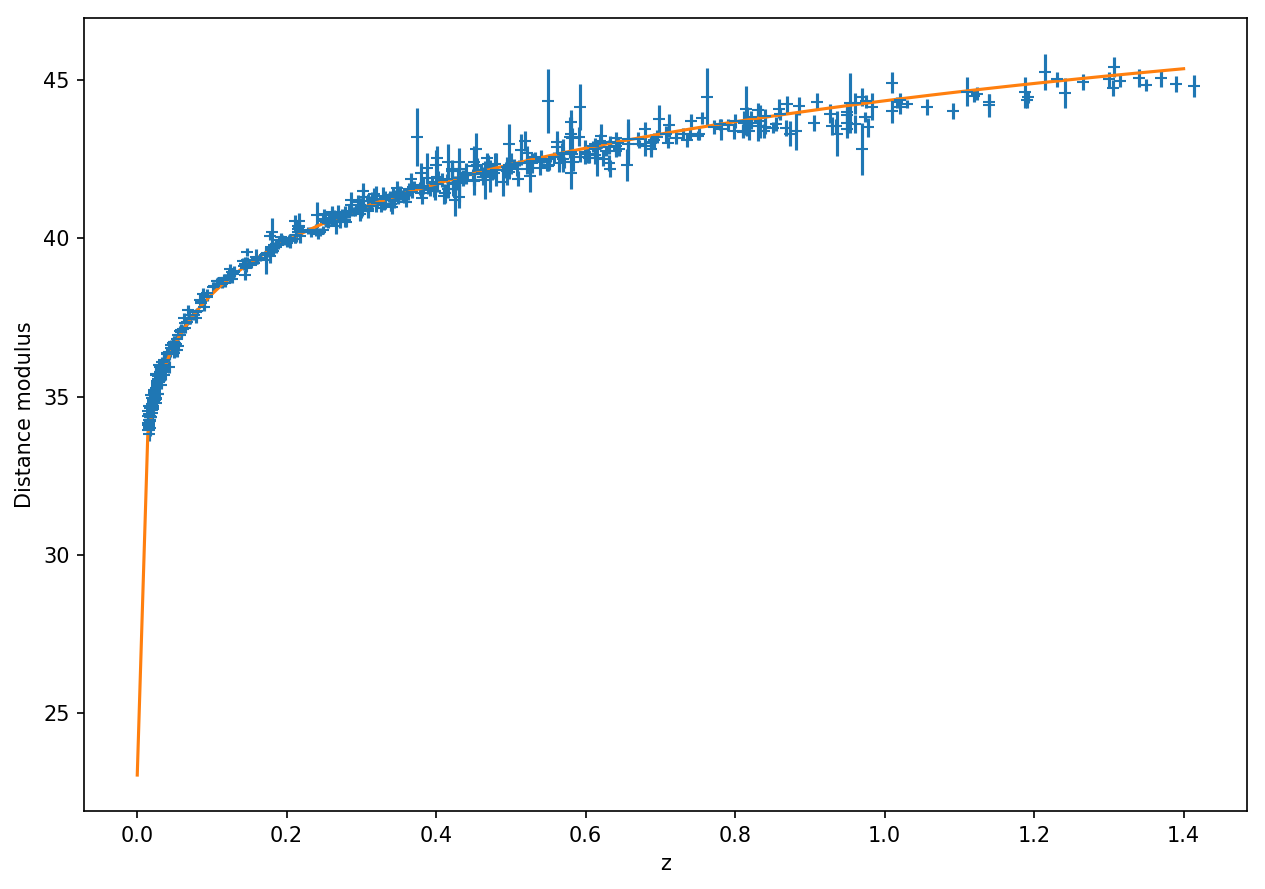

In [7]:
plt.errorbar(SNe_df['z'],SNe_df['d_mod'],yerr=SNe_df['err_d_mod'],fmt='_')
plt.plot(z_grid,flatLCDM_result(z_grid))
plt.xlabel('z'); plt.ylabel('Distance modulus')

In [8]:
Ode_grid = np.linspace(0,1,200)
Ode_chi_73 = [sum((SNe_df[mask]['d_mod']-dist_mod(SNe_df[mask]['z'],Hz_flatLCDM,(Ode,73.8)))**2/SNe_df[mask]['err_d_mod']) 
           for Ode in Ode_grid]
Ode_chi_69 = [sum((SNe_df[mask]['d_mod']-dist_mod(SNe_df[mask]['z'],Hz_flatLCDM,(Ode,69)))**2/SNe_df[mask]['err_d_mod']) 
           for Ode in Ode_grid]

0.8492462311557789
0.6934673366834171


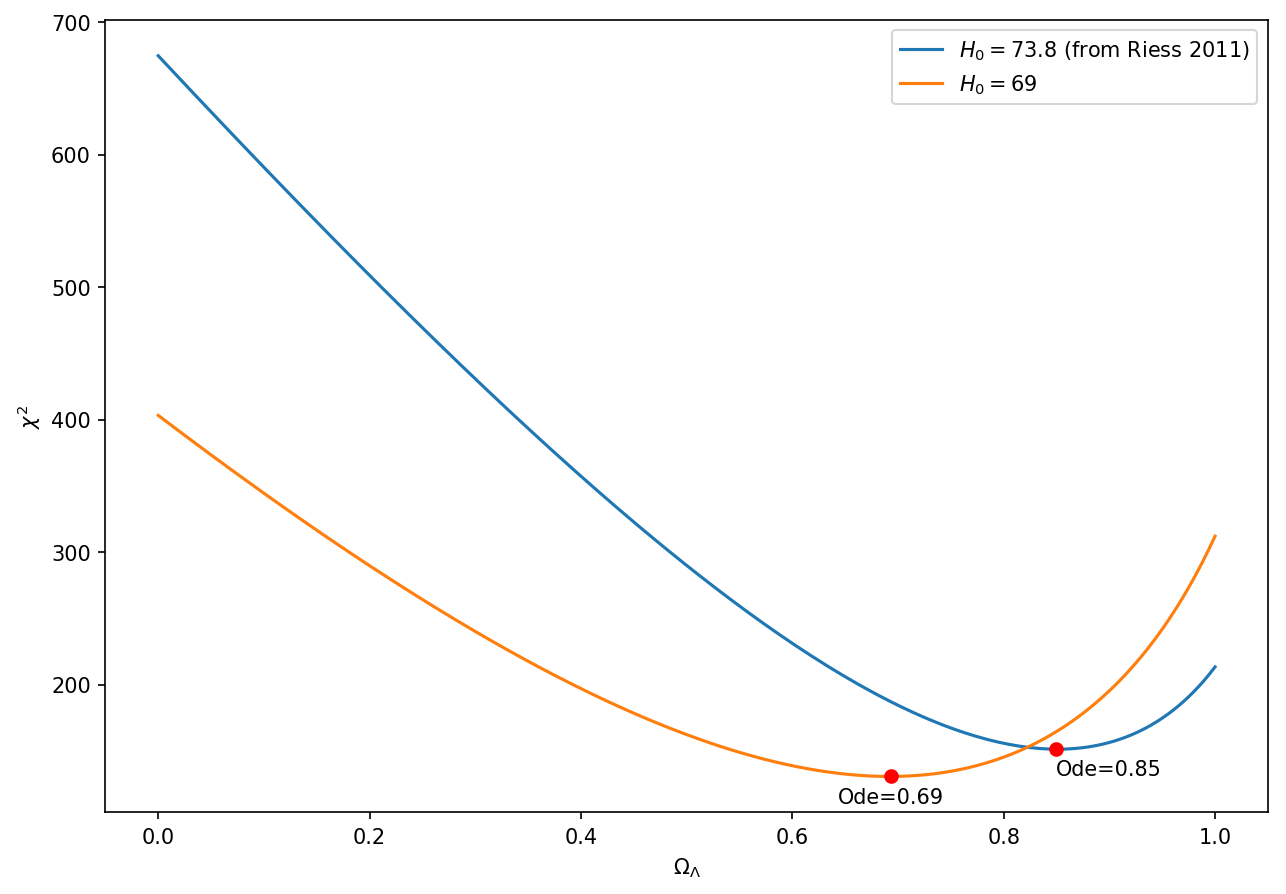

In [9]:
plt.plot(Ode_grid,Ode_chi_73,label=r'$H_0=73.8$ (from Riess 2011)')
plt.plot(Ode_grid,Ode_chi_69,label=r'$H_0=69$')
plt.xlabel(r'$\Omega_\Lambda$'); plt.ylabel(r'$\chi^2$')
plt.legend()
ind_73 = np.argmin(Ode_chi_73)
plt.plot(Ode_grid[ind_73],Ode_chi_73[ind_73],'ro')
plt.text(Ode_grid[ind_73],Ode_chi_73[ind_73]-20,'Ode={:.2f}'.format(Ode_grid[ind_73]))
print Ode_grid[ind_73]
ind_69 = np.argmin(Ode_chi_69)
print Ode_grid[ind_69]
plt.plot(Ode_grid[ind_69],Ode_chi_69[ind_69],'ro')
plt.text(Ode_grid[ind_69]-.05,Ode_chi_69[ind_69]-20,'Ode={:.2f}'.format(Ode_grid[ind_69]))
plt.savefig('chi2_Ode.png')

In [10]:
def chi2_nosys_flatLCDM(alfa,beta,Mb,Ode,Ok=0,w=-1,data=SNe_df,sigma_ext=sigma_ext):
    Om = 1-Ode
    mu_B = data['mb']+alfa*data['x1']-beta*data['color']-Mb
    mu_cosmo = dist_mod(data['z'],Hz_flatLCDM,(Ode,))
    sigma_lc = data['err_mb']**2+alfa**2*data['err_x1']**2+beta**2*data['err_color']**2
    return sum((mu_B-mu_cosmo)**2/(sigma_lc+sigma_ext))

### Calculate Deceleration parameter $q$

In [11]:
# using equation 3.48 of the cosmology notes
q0 = Om/2-Ode
print 'The deceleration parameter is {}, thus, the expansion of the universe is accelerated'.format(q0)

The deceleration parameter is -0.959101571114, thus, the expansion of the universe is accelerated


### Calculate $H_0$
Filter the SNe sample to get the low redshift subset, and make a linear fit to it. The slope will be an aproximation of $H_0$

In [10]:
z_cut = 0.03
H0_mask = (SNe_df['z']<z_cut) & mask

v_SNe = const.c/1000.*SNe_df[H0_mask]['z']

dL_SNe = 10**((SNe_df[H0_mask]['d_mod']-25+2.5*np.log10(1+SNe_df[H0_mask]['z']))/5)
dL_max = 120

v_SNe=v_SNe[dL_SNe<dL_max]
dL_SNe=dL_SNe[dL_SNe<dL_max]
H0_fit, intercept, r, p, err = stat.linregress(dL_SNe,v_SNe)
H0_curvefit = opt.curve_fit(lambda d,H: H*d, dL_SNe, v_SNe, p0=H0)[0][0]

In [11]:
age_fit = 1/H0_fit*1e6*3.86e13/3.154e7/1e9
age_curvefit = 1/H0_curvefit*1e6*3.86e13/3.154e7/1e9
print 'The value of H0 forcing v(z=0)=0 is H0 = {} km/s/Mpc,\nwhich means \
an aproximate age of the universe of {} Myr'.format(H0_curvefit,age_curvefit)
print '\nThe value of H0 NOT forcing v(z=0) is H0 = {0} km/s/Mpc with v(z=0) = {1} km/s,\n\
which means an aproximate age of the universe of {2} Myr'.format(H0_fit,intercept,age_fit)

The value of H0 forcing v(z=0)=0 is H0 = 68.2925192877 km/s/Mpc,
which means an aproximate age of the universe of 17.9205973384 Myr

The value of H0 NOT forcing v(z=0) is H0 = 66.4035736649 km/s/Mpc with v(z=0) = 153.499352269 km/s,
which means an aproximate age of the universe of 18.4303746295 Myr


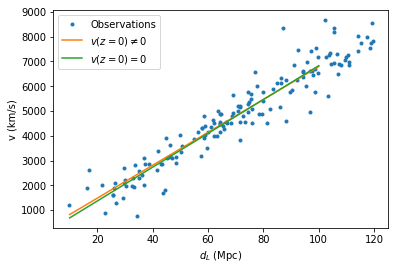

In [12]:
dL_grid = np.linspace(10,100)
plt.plot(dL_SNe,v_SNe,'.',label='Observations')
plt.plot(dL_grid,dL_grid*H0_fit+intercept,label=r'$v(z=0)\neq 0$')
plt.plot(dL_grid,dL_grid*H0_curvefit,label='$v(z=0)= 0$')
plt.xlabel('$d_L$ (Mpc)'); plt.ylabel('v (km/s)')
plt.legend()

### Calculate $w$, the dark matter equation of state parameter

In [13]:
def Hz_w_cte(z,Ode,w):
    H0 = 73.24; Om = 1-Ode
    Hz = H0*np.sqrt(Om*(1+z)**3+Ode*np.exp(3*(1+w)*np.log(1+z)))
    return Hz

H0 = 73.24
# Create astropy model
w_cte_aModel = amod.custom_model(lambda z,Ode=.3,w=-1 : dist_mod(z,Hz_w_cte,(Ode,w)))
 
init_w_cte = w_cte_aModel()
fit_w_cte = afit.LevMarLSQFitter()
w_cte_result = fit_w_cte(init_w_cte,
                               SNe_df[mask]['z'],
                               SNe_df[mask]['d_mod'],
                               weights=SNe_df[mask]['err_d_mod'])
w_cte_err = np.sqrt(np.diag(fit_w_cte.fit_info['param_cov']))
Om_w_cte = w_cte_result.Ode.value
Ode_w_cte = 1-Om_w_cte

In [14]:
print 'The fitted values are:\n\tOde : {:.2f}({:.2f})\n\tw : {:.2f}({:.2f})'.format(Ode_w_cte,
                                                                                    w_cte_err[0],
                                                                                    w_cte_result.w.value,
                                                                                    w_cte_err[1])

The fitted values are:
	Ode : 0.45(0.03)
	w : -5.81(2.11)


Text(0,0.5,u'Distance modulus')

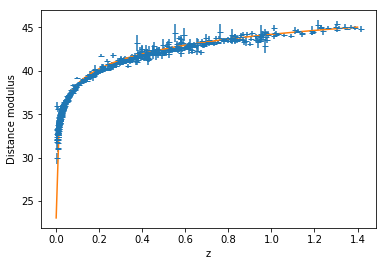

In [15]:
plt.errorbar(SNe_df['z'],SNe_df['d_mod'],yerr=SNe_df['err_d_mod'],fmt='_')
plt.plot(z_grid,w_cte_result(z_grid))
plt.xlabel('z'); plt.ylabel('Distance modulus')

#### Study the effect of Peculiar Velocities

From Davis et al. 2011:

$$
(1+z)=(1+\bar{z})(1-v_\odot/c + v_{SN}/c)
$$

where $z$ is the observed redsfhit, and $\bar{z}$ is the cosmological redshift. 

Reference values: $v_\odot$ = 371km/s, $\sigma_{SN}$ = 300km/s).

In [16]:
vsun = 371.
vsn = 300.

mask = np.isfinite(SNe_df['z']) & np.isfinite(SNe_df['d_mod'])
z_obs = SNe_df[mask]['z']
N = len(z_obs)
v_SN = np.random.normal(loc=0,scale=300,size=N)
# Note: the redhifts should already be corrected to vsun, therefore, correcting it again makes no sense.
z_bar = (1+z_obs)/(1-(vsun+vsn)*1000/const.c)-1

d_mod = SNe_df[mask]['d_mod']
d_mod_err = SNe_df[mask]['err_d_mod']

cosmo_params = [73.8,.3,0.7]
res_pec = opt.curve_fit(lambda z,*p: dist_mod(z,Hz_flatLCDM,p),
                    xdata=z_bar,
                    ydata=d_mod,
                    sigma = d_mod_err, absolute_sigma=True,
                    p0=cosmo_params)

res_err_pec = np.sqrt(np.diag(res_pec[1]))
H0,Om,Ode = res_pec[0]

print 'The fitted parameters *WITH* peculiar velocities are:\n\tH0={1}({4})\n\tOm={2}({5})\
\n\tOk={0}\n\tOde={3}({6})'.format(1-sum(res_pec[0][1:]),*np.append(res_pec[0],res_err_pec))

print 'The fitted parameters *WITHOUT* considering peculiar velocities are:\n\tH0={1}({4})\n\tOm={2}({5})\
\n\tOk={0}\n\tOde={3}({6})'.format(1-sum(res[0][1:]),*np.append(res[0],res_err))


plt.errorbar(z_bar,d_mod,yerr=d_mod_err,fmt='_', label = r'$z_{bar}$')
plt.errorbar(z_obs,d_mod,yerr=d_mod_err,fmt='_', label = r'$z_{obs}$')
plt.plot(z_grid,dist_mod(z_grid,Hz_flatLCDM,res_pec[0]))
plt.legend(); plt.xlabel('Redshift $z$'); plt.ylabel(r'Distance Modulus $\mu$')


TypeError: Hz_flatLCDM() takes exactly 2 arguments (4 given)

## Questions

* How to fit? Is curve_fit enough?
* Do we have to explore models different than flat Universe?
* In the study of peculiar velocities, we're assuming that the distance modulus remains unchanged after incorporating vsn and Vsun. however, the distance modulus depends on the luminosity distance, which according to Davis et al. (2011), should also be corrected for peculiar velocities. The results presented in this notebook assume $\mu$ is unchanged.


Last question: It's possible to do it theoretically as an order of magnitude.

# Determination of $H_0$
